In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
class DataLoader:
    '''The following class will be used to load the data and apply few initial filtering/preprocessing steps'''
    @classmethod
    def load(cls, asset: str,
             sampling: str = '1H',
             year_start: int = 2000,
             year_end: int = None):
        if os.path.exists(f'data/{asset}.csv'):
            data = pd.read_csv(f'data/{asset}.csv', header=None)
        else:
            raise FileNotFoundError('{asset}.csv was not found!')
        data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        data.iloc[:, 1:-1] /= 10e3
        data['Date'] = pd.to_datetime(data['Date'])
        if year_end is None:
            year_end = data['Date'].dt.year.unique()[-1]
        data = data[(data['Date'].dt.year >= year_start) & (data['Date'].dt.year <= year_end)]
        data.reset_index(inplace=True, drop=True)
        if sampling != '1H':
            data = cls._resample(data, sampling)
        data = cls.featurise(data, sampling)
        # for each observation t add t+1 binary target
        data['target'] = np.sign(data['ln_Close'].shift(-1))
        # dropna from the last row
        data.dropna(inplace=True)
        # due to the nature of our data (only 2 decimal points) there are few occasions when close price is unchanged
        # replacing them with the previous target to keep it binary
        frac = round(data[data['target'] == 0].shape[0] / data.shape[0], 2)
        print(f'Warning: {frac} fraction of data has zero targets. Replacing it with previous target.')
        # data.loc[data['target'] == 0, 'target'] = 1
        data['target'] = data['target'].replace(to_replace=0, method='ffill')

        return data

    @staticmethod
    def _resample(data: pd.DataFrame, sampling):
        data.set_index('Date', inplace=True)
        data = data.resample(sampling).agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last'})
        data.dropna(inplace=True)
        data.reset_index(inplace=True)
        return data

    @staticmethod
    def featurise(data: pd.DataFrame, sampling: str):
        '''
            method to add additional features to the dataset
        '''
        # add log returns for the Close prices
        data['ln_Close'] = np.log(data['Close'] / data['Close'].shift(1))

        # simple ratios/diffs
        data['shadow_up'] = data['High'] - np.maximum(data['Close'], data['Open'])
        data['shadow_down'] = np.minimum(data['Close'], data['Open']) - data['Low']
        data["hl_ratio"] = data['High'] / data['Low']
        data["oc_diff"] = data['Open'] - data['Close']

        # Moving averages - 20, 50, 100, 200 sessions (adjusted by the sampling)
        data['MA20'] = data['Close'].rolling(window=20).mean()
        data['MA50'] = data['Close'].rolling(window=50).mean()
        data['MA100'] = data['Close'].rolling(window=100).mean()
        data['MA200'] = data['Close'].rolling(window=200).mean()

        # Exponential weighted moving averages - 8, 20 sessions
        data['EWMA8'] = data['Close'].ewm(span=8, min_periods=8, adjust=False).mean()
        data['EWMA20'] = data['Close'].ewm(span=20, min_periods=20, adjust=False).mean()
        # Moving average convergence/divergence
        data['MACD'] = data['EWMA20'] - data['EWMA8']

        # Bollinger Bands - 20 sessions, 2 std dev
        data['MA20_std'] = data['Close'].rolling(window=20).std()
        data['BB_high'] = data['MA20'] + 2 * data['MA20_std']
        data['BB_low'] = data['MA20'] - 2 * data['MA20_std']
        data.drop(['MA20_std'], axis=1, inplace=True)

        # RSI
        delta = data['Close'].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        ema_up = up.ewm(com=14, min_periods=14, adjust=False).mean()
        ema_down = down.ewm(com=14, min_periods=14, adjust=False).mean()
        rs = ema_up / ema_down
        data['RSI'] = 100 - (100 / (1 + rs))
        del delta, up, down, ema_up, ema_down, rs

        # realised volatility - 8, 20 sessions (https://www.realvol.com/VolFormula.htm)
        samples_in_session = {'1H': 7, '3H': 3, '1D': 1}
        rvol = lambda x: np.sqrt(np.sum(x ** 2) * 252 / (len(x) // samples_in_session[sampling])) * 100
        data['VOL8'] = data['ln_Close'].rolling(8).apply(rvol)
        data['VOL20'] = data['ln_Close'].rolling(20).apply(rvol)

        data.dropna(inplace=True)

        return data

In [73]:
df = DataLoader.load('ibm', sampling='3H')

In [74]:
df_1h = DataLoader.load('ibm', sampling='1H')
df_1d = DataLoader.load('ibm', sampling='1D')
df_1h.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'target'], axis=1, inplace=True)
df_1d.drop(['Open', 'High', 'Low', 'Close', 'target'], axis=1, inplace=True)
df_1h.columns = [x + '_1H' for x in df_1h.columns]
df_1d.columns = [x + '_1D' for x in df_1d.columns]
df = df.merge(df_1h, left_on='Date', right_on='Date_1H')
df.drop(['Date_1H'], axis=1, inplace=True)
df['tmp'] = df['Date'].dt.date.astype('datetime64')
df = df.merge(df_1d, left_on='tmp', right_on='Date_1D')
df.drop(['tmp', 'Date_1D'], axis=1, inplace=True)
del df_1h, df_1d

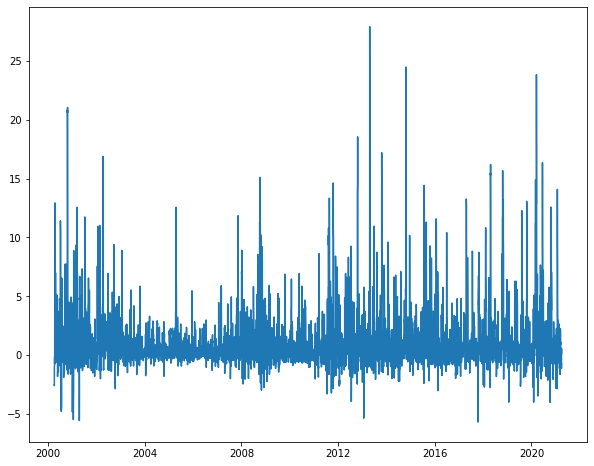

In [55]:
plt.figure(figsize=(10, 8))
plt.plot(df['Date'], df['BB_high'] - df['BB_high_1H'])


In [56]:
(df['BB_high'] - df['BB_high_1H']).describe()

count    15786.000000
mean         1.241171
std          2.417478
min         -5.689430
25%         -0.026618
50%          0.559511
75%          1.725029
max         27.916033
dtype: float64